In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from collections import Counter

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



ModuleNotFoundError: No module named 'torch'

In [2]:
# Define transformations with data augmentation (Highlighted Change 1)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomRotation(10),  # Random rotation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])



Train set class distribution: Counter({0: 407, 1: 204})


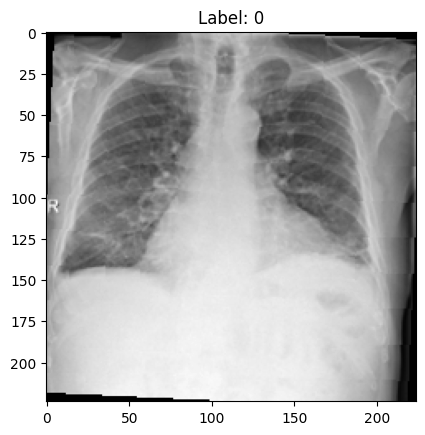

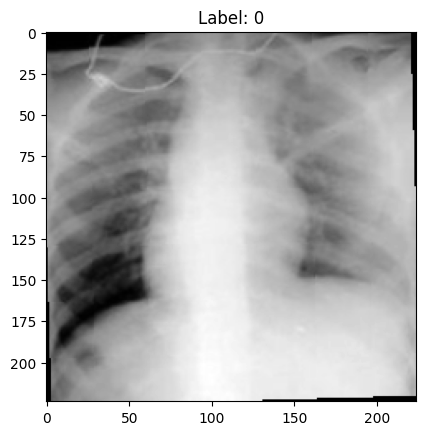

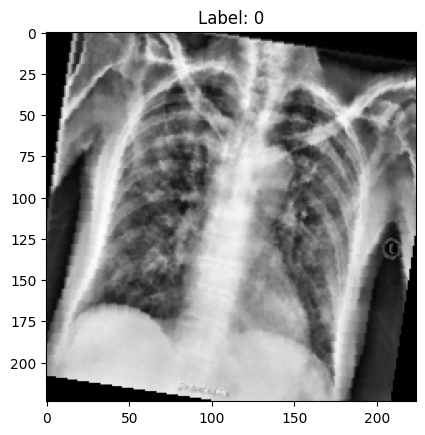

In [3]:
# Load dataset and automatically split into train, val, and test sets (Highlighted Change 2)
data_path = r'C:\Users\sarva\Desktop\nf\code\covid-dectection-CNN\test'
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Define dataset sizes
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Split datasets
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verify dataset balance
labels = [label for _, label in train_dataset]
print(f"Train set class distribution: {Counter(labels)}")

# Visualize some images and labels
for i in range(3):
    img, label = train_dataset[i]
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f'Label: {label}')
    plt.show()



In [4]:
# Define the model with BCEWithLogitsLoss compatibility (No Changes Here)
class CovidNet(nn.Module):
    def __init__(self):
        super(CovidNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 26 * 26, 64)
        self.fc2 = nn.Linear(64, 1)  # Raw output for BCEWithLogitsLoss

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.dropout(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # No Sigmoid here
        return x

In [5]:
# Initialize the model, loss function, optimizer, and scheduler (Highlighted Change 3)
model = CovidNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [8]:
# Start training with validation and model saving (Highlighted Change 4)
print('Starting training...')
num_epochs = 15
best_val_loss = float('inf')  # Track the best validation loss
model_save_path = r"C:\Users\sarva\Desktop\nf\code\edochetta\model3.pth"  # Path to save the model

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1, 1).float()  # Ensure labels are in the correct shape

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()  # Apply Sigmoid here for prediction
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    print(f'Epoch {epoch + 1} Training Loss: {running_loss / len(train_loader):.4f} Accuracy: {train_accuracy:.2f}%')

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.view(-1, 1).float()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    val_loss /= len(val_loader)
    print(f'Epoch {epoch + 1} Validation Loss: {val_loss:.4f} Accuracy: {val_accuracy:.2f}%')

    # Step the scheduler
    scheduler.step()

    # Save the model if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved at epoch {epoch + 1}")

print('Finished Training')
 
                                        

Starting training...
Epoch 1 Training Loss: 0.3529 Accuracy: 83.63%
Epoch 1 Validation Loss: 0.4582 Accuracy: 86.15%
Model saved at epoch 1
Epoch 2 Training Loss: 0.3404 Accuracy: 85.60%
Epoch 2 Validation Loss: 0.4964 Accuracy: 80.77%
Epoch 3 Training Loss: 0.3564 Accuracy: 84.94%
Epoch 3 Validation Loss: 0.4667 Accuracy: 83.85%
Epoch 4 Training Loss: 0.3494 Accuracy: 83.96%
Epoch 4 Validation Loss: 0.4700 Accuracy: 84.62%
Epoch 5 Training Loss: 0.3527 Accuracy: 83.96%
Epoch 5 Validation Loss: 0.4617 Accuracy: 84.62%
Epoch 6 Training Loss: 0.3641 Accuracy: 84.12%
Epoch 6 Validation Loss: 0.4696 Accuracy: 84.62%
Epoch 7 Training Loss: 0.3423 Accuracy: 82.98%
Epoch 7 Validation Loss: 0.4444 Accuracy: 83.85%
Model saved at epoch 7
Epoch 8 Training Loss: 0.3595 Accuracy: 84.29%
Epoch 8 Validation Loss: 0.4743 Accuracy: 85.38%
Epoch 9 Training Loss: 0.3333 Accuracy: 83.96%
Epoch 9 Validation Loss: 0.4514 Accuracy: 83.08%
Epoch 10 Training Loss: 0.3480 Accuracy: 84.45%
Epoch 10 Validation L

In [7]:
# Test the model (Highlighted Change 5)
print('Testing the model...')
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1, 1).float()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f} Accuracy: {test_accuracy:.2f}%")


Testing the model...
Test Loss: 0.3691 Accuracy: 87.12%
